In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from torch import nn
import scipy.io as sio
from IPython import display
import os
from nn_mri import ImageFitting_set, SineLayer, get_mgrid
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from skimage.transform import rescale

In [36]:
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, 
                 hidden_layers, out_features, 
                 first_omega_0=30., 
                 hidden_omega_0=30.):
        super().__init__()
        # self.net is the INR that calculates signal intensities for its inputs
        self.net = []
        self.final_linear = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            self.final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0)
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))

        self.net.append(self.final_linear)

        self.net = nn.Sequential(*self.net)
        
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(False)
        output = self.net(coords)

        return output

In [37]:
class PN(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        self.tanh = nn.Tanh()  
        self.perturb_linear = nn.Linear(in_features + 1, hidden_features)
        self.perturb_linear2 = nn.Linear(hidden_features, 2)
        
    def forward(self, coords, sample=0, eps=0):
        coords = coords.clone().detach().requires_grad_(False)
        acq = torch.tensor([sample/10.], dtype=torch.float).cuda()
        acq = acq.repeat(coords.size(0),1)
        perturbation = self.perturb_linear(torch.cat((coords, acq),-1))
        perturbation = self.tanh(perturbation)
        perturbation = self.perturb_linear2(perturbation)
        pertubation = eps*self.tanh(perturbation)
        
        return pertubation

In [38]:
# Fourier feature mapping
def input_mapping(x, B):
  if B is None:
    return x
  else:
    x_proj = torch.matmul(2.*np.pi*x, B.T)
    return torch.concatenate([torch.sin(x_proj), torch.cos(x_proj)], axis=-1)

In [46]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"
mapping_size = 256
B_gauss = np.random.normal(size=(mapping_size, 2))
scale = 1.
B = torch.from_numpy(B_gauss * scale).float().cuda()

In [47]:
filename = '/home/gundogdu/toy2.mat'
acquisitions = sio.loadmat(filename)['pertubed_acq']
filename2 = '/home/gundogdu/nomo.mat'
nomo = sio.loadmat(filename2)['x_sub']

/home/gundogdu/MRI-super-resolution/implicit-neural-representations/nn_mri.py:168: RuntimeWarning: invalid value encountered in add
  self.mean = sum(self.orig)/len(self.orig)


0.0007367247017100453


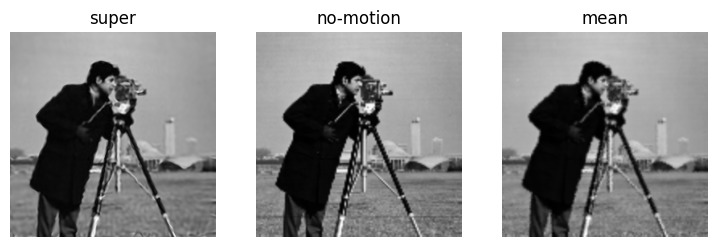

0.00024906796170398593


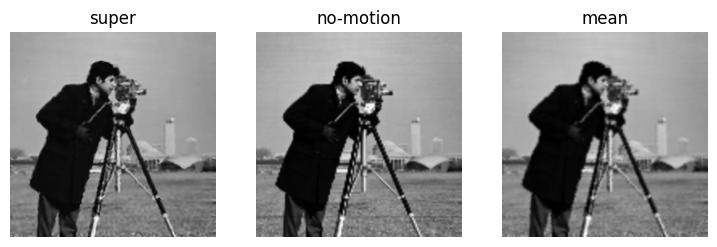

KeyboardInterrupt: 

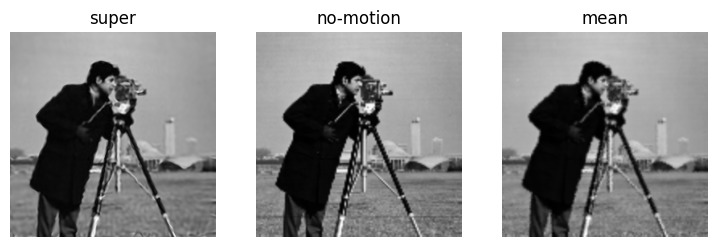

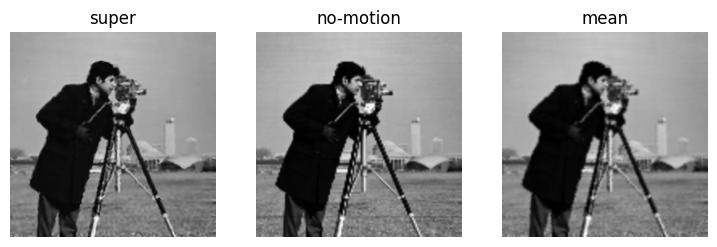

In [49]:


mean_img = np.mean(acquisitions,-1)
img_dataset = []
for inx in range(acquisitions.shape[-1]):
    img = acquisitions[:,:,inx]
    img_dataset.append(Image.fromarray(img))
mean_dataset = ImageFitting_set([Image.fromarray(mean_img)])
dataset = ImageFitting_set(img_dataset)

INR = Siren(in_features=2*mapping_size, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3)
INR.cuda()
PerturbNet = PN(in_features=2*mapping_size, hidden_features=128)
PerturbNet.cuda()

inr_params = list(INR.parameters())
inr_optim = torch.optim.Adam(lr=1e-4, params=inr_params)
perturb_params = list(PerturbNet.parameters())
perturb_optim = torch.optim.Adam(lr=1e-6, params=perturb_params)
torch.cuda.empty_cache()
ctr = 0
new_loss = 1000

while True:
    ctr += 1

    if ctr < 500:
        ground_truth, model_input  = mean_dataset.pixels[0], mean_dataset.coords[0]
        ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
        model_input = input_mapping(model_input, B)
        ground_truth /= ground_truth.max()
        model_output = INR.forward(model_input)
        loss = ((model_output - ground_truth)**2).mean()
        inr_optim.zero_grad()
        loss.backward()
        inr_optim.step()
    else:
        if ctr%2:
            ground_truth, model_input  = mean_dataset.pixels[0], mean_dataset.coords[0]
            ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
            model_input = input_mapping(model_input, B)
            ground_truth /= ground_truth.max()
            model_output = INR.forward(model_input)
            loss = ((model_output - ground_truth)**2).mean()
            inr_optim.zero_grad()
            loss.backward()
            inr_optim.step()
        else:
            for sample in range(len(dataset)):
                ground_truth, model_input  = dataset.pixels[sample], dataset.coords[sample]
                ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
                model_input = input_mapping(model_input, B)
                ground_truth /= ground_truth.max()
                perturbed_input = PerturbNet.forward(model_input, sample, 1/128.)
                perturbed_input = input_mapping(perturbed_input, B)
                model_output = INR.forward(perturbed_input)
                if not sample:
                    loss = ((model_output - ground_truth)**2).mean()
                else:
                    loss += ((model_output - ground_truth)**2).mean()
        
            perturb_optim.zero_grad()
            loss.backward()
            perturb_optim.step()
    if not ctr%500:
        print(new_loss)
        model_input  = get_mgrid(256, 2).cuda()
        model_input  = input_mapping(model_input, B)
        recon = INR.forward(model_input).cpu().view(256,256).detach().numpy()
        fig, ax = plt.subplots(1,3,figsize=(9,3))
        ax[0].imshow(recon, cmap='gray')
        ax[0].set_title('super')
        ax[1].imshow(rescale(nomo,2), cmap='gray')
        ax[1].set_title('no-motion')
        ax[2].imshow(rescale(mean_img,2), cmap='gray')
        ax[2].set_title('mean')
        for axi in range(3):
            ax[axi].axis('off')
        display.display(plt.gcf())  
    if ctr>10000 and loss.item() > new_loss:
        break      
    else:
        new_loss = loss.item()
print('Done')
PATH = 'toy_model.pt'
#torch.save(img_siren.state_dict(), PATH)

In [52]:
img_ctr = 1
for ctr in range(5000):
    if not ctr%100:
        img_ctr += 1
print(img_ctr)

51


In [17]:
sio.savemat('output.mat', {'out':recon})

In [18]:
class kiwi:
    def __init__(self, img_id):

        self.img_id = img_id
        file_address = '/home/gundogdu/matfiles'
        filename = os.path.join(file_address, img_id)
        self.dwi = sio.loadmat(filename)['img']

In [19]:
file_address = '/home/gundogdu/matfiles'
kiwi_scans = []
for f in os.listdir(file_address):
    kiwi_scans.append(kiwi(f))

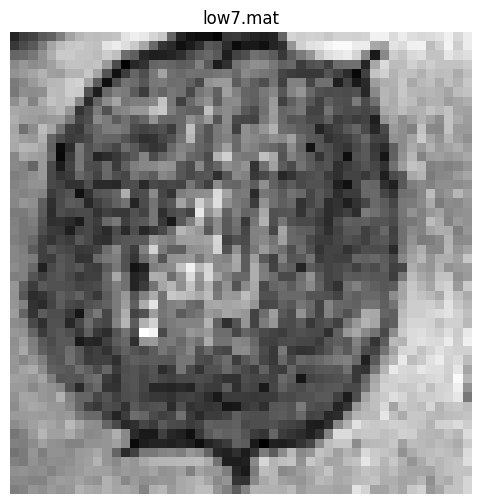

In [20]:
_kiwi = kiwi_scans[7]
dwi = _kiwi.dwi[40:90,20:70]
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(dwi, cmap='gray')
ax.set_title(_kiwi.img_id)
ax.axis('off')
plt.show()

In [21]:
img_dataset = []

dataset = ImageFitting_set(img_dataset)

/home/gundogdu/MRI-super-resolution/implicit-neural-representations/nn_mri.py:168: RuntimeWarning: invalid value encountered in add
  self.mean = sum(self.orig)/len(self.orig)


5.308092113409657e-06


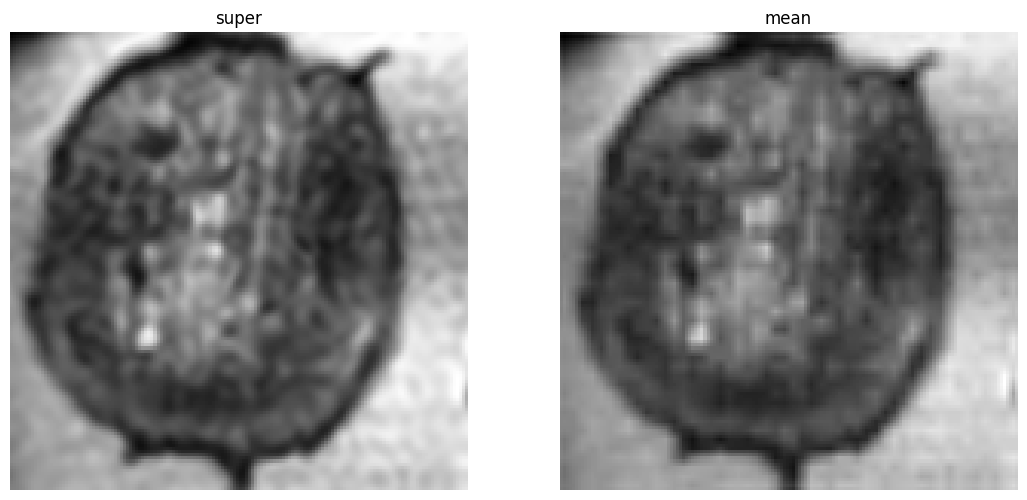

1.2021581596854958e-06


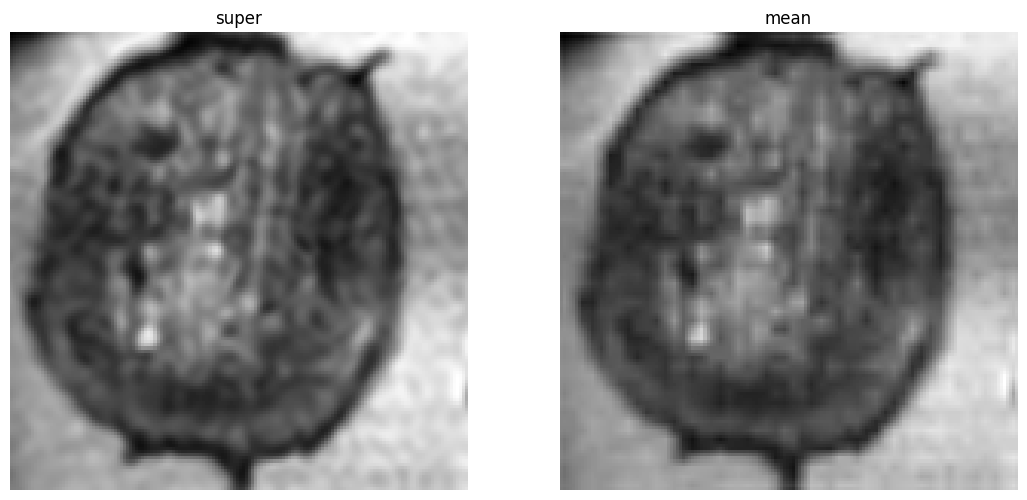

5.956409268037532e-07


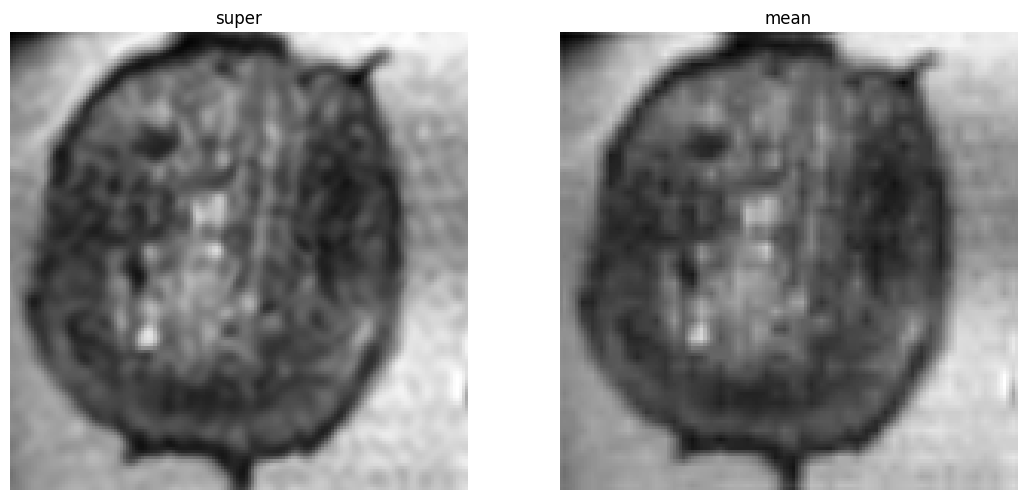

2.6343494141656265e-07


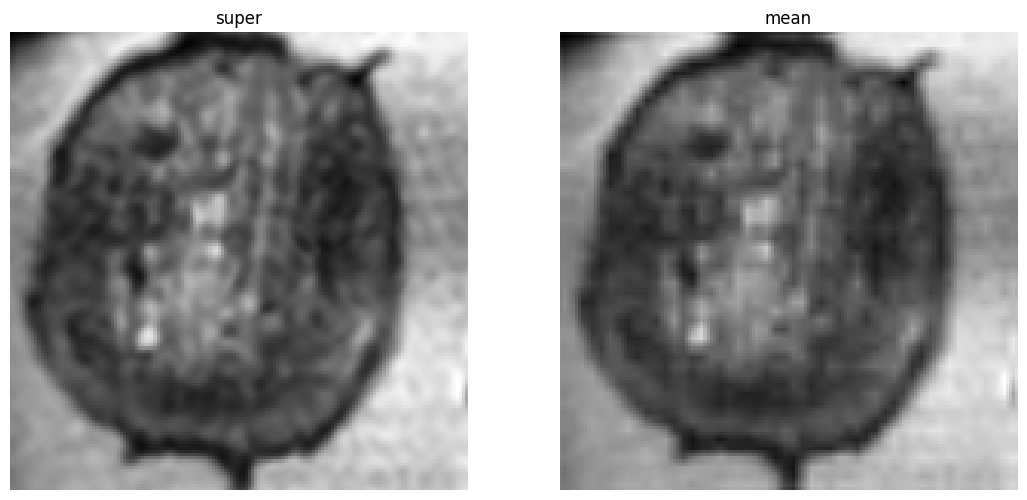

1.858570431068074e-05


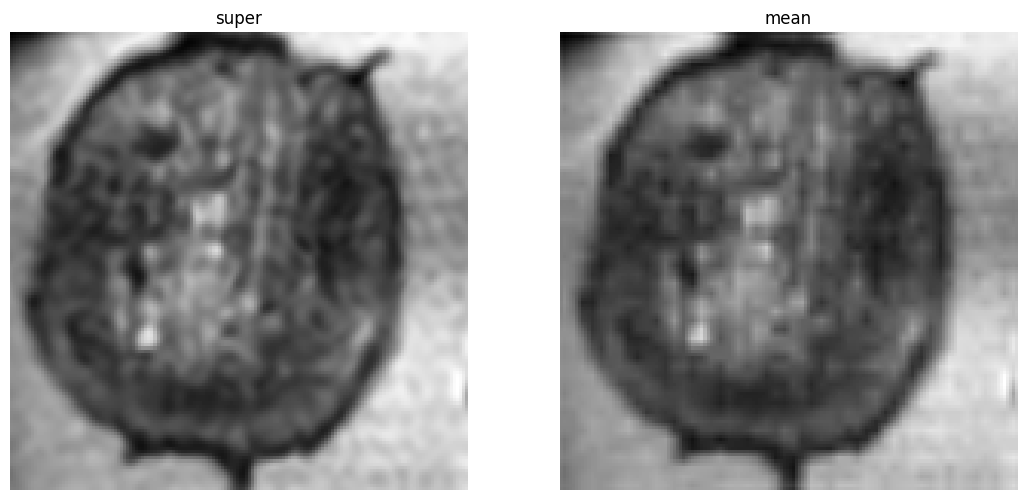

7.462070783503805e-08


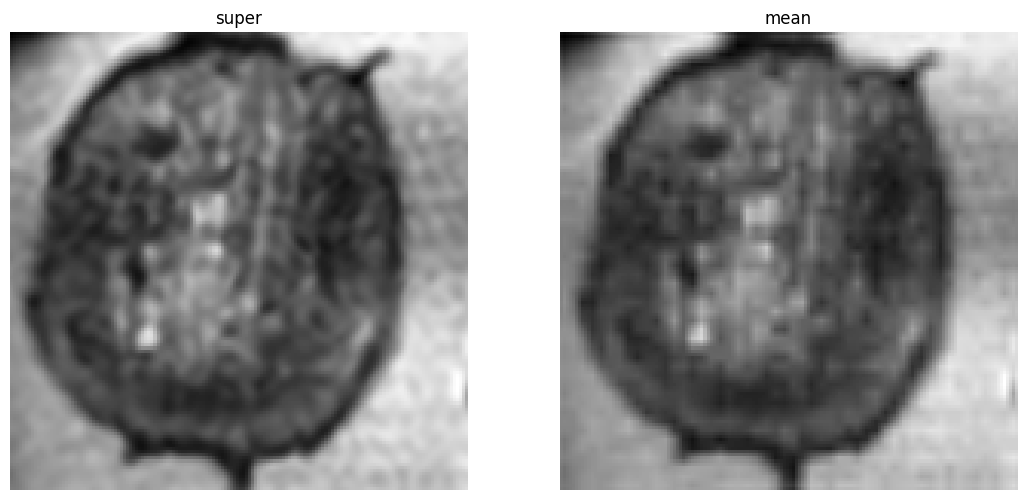

3.1605331685113924e-08


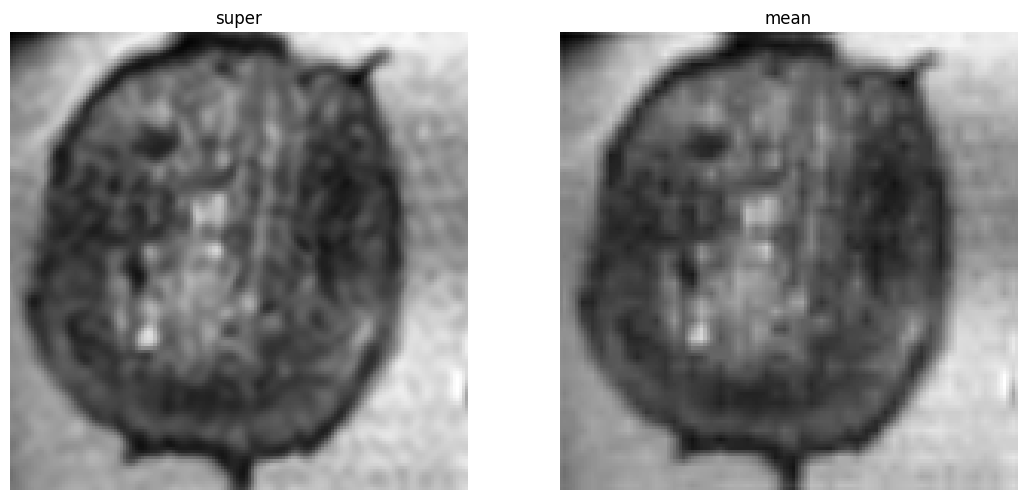

3.314849195135139e-08


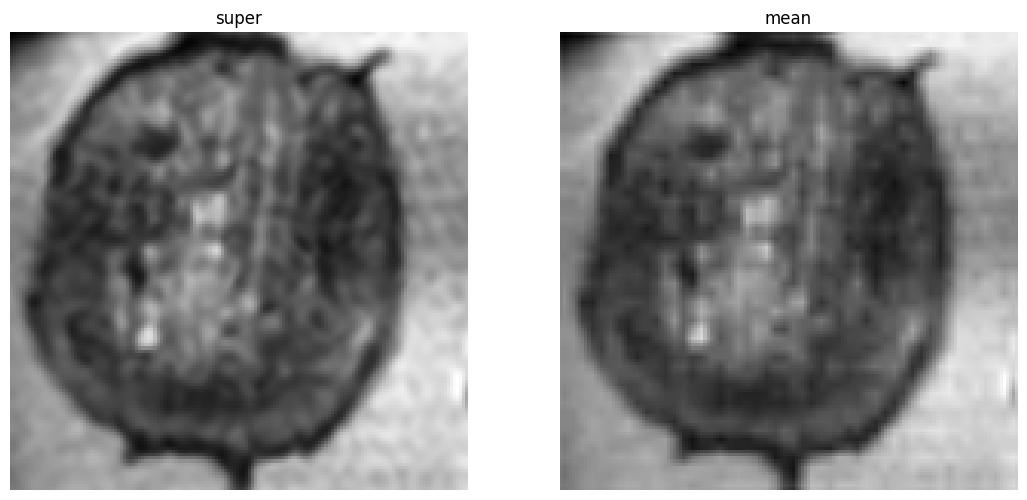

1.2752805034210724e-08


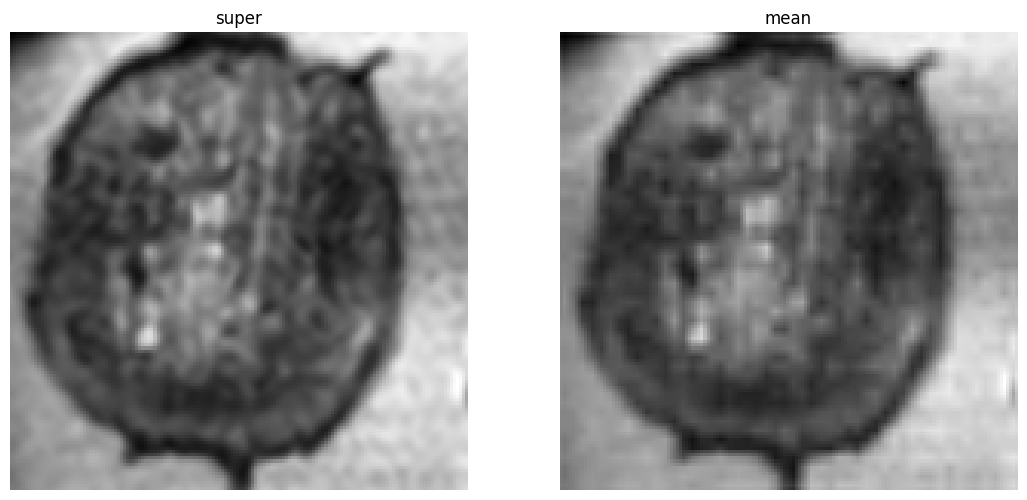

4.0938863094197586e-05


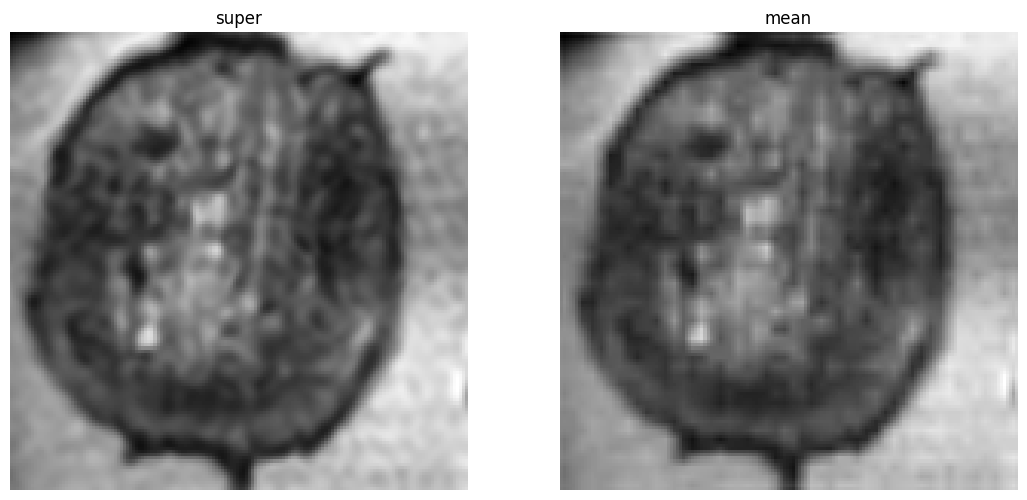

8.716082078308318e-09


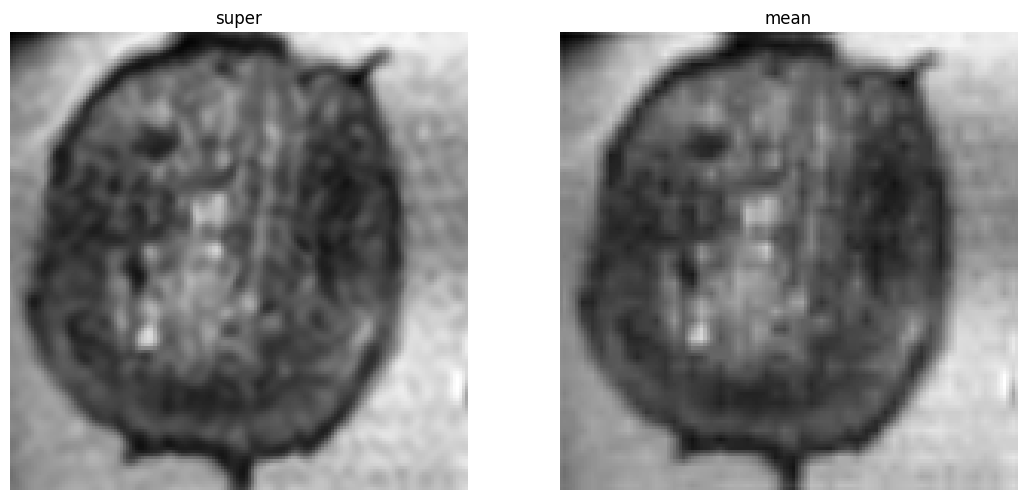

3.328316511286289e-09


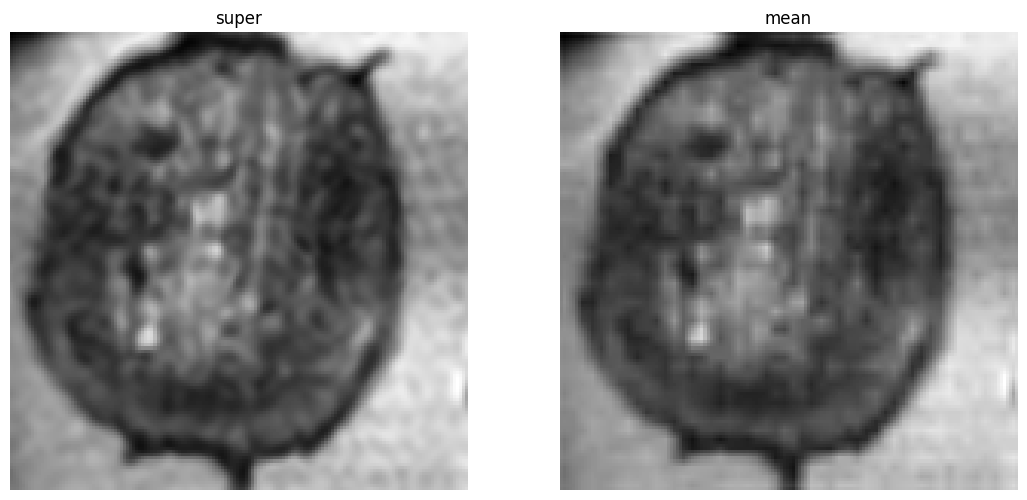

KeyboardInterrupt: 

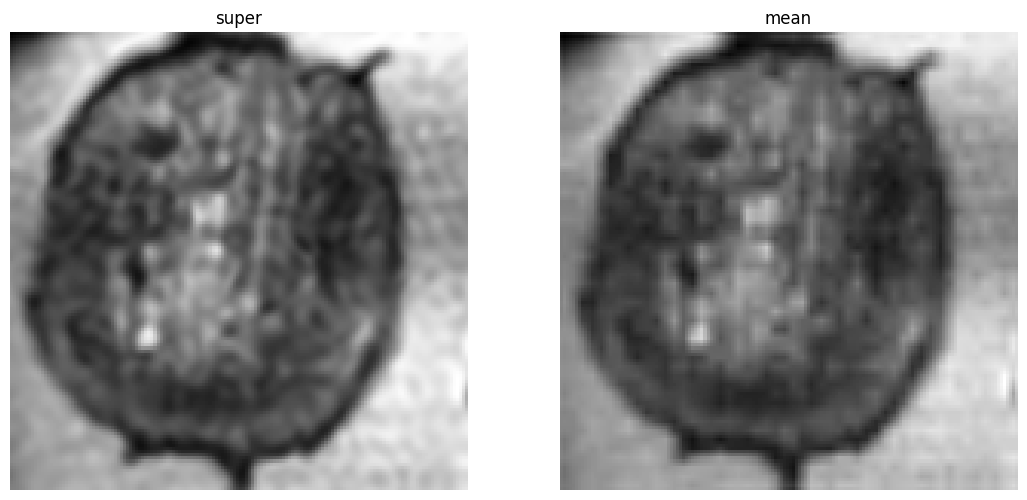

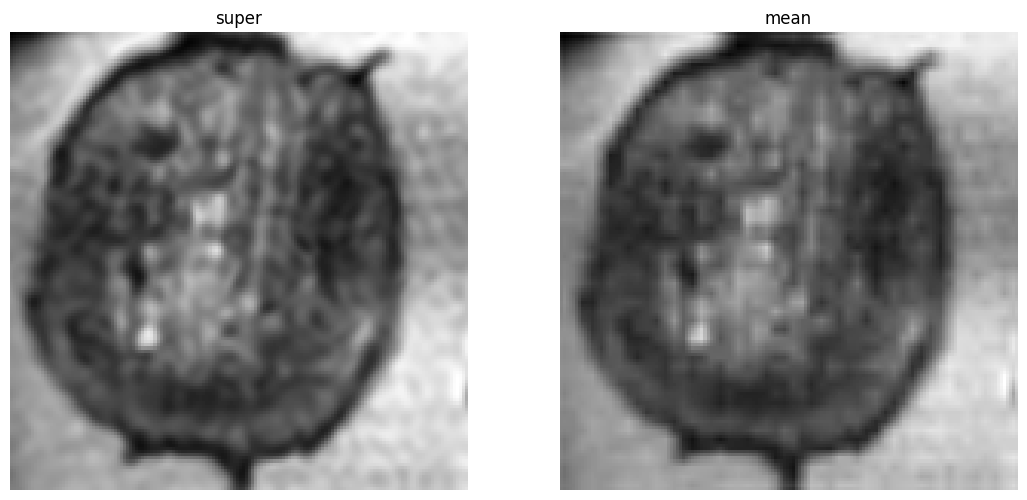

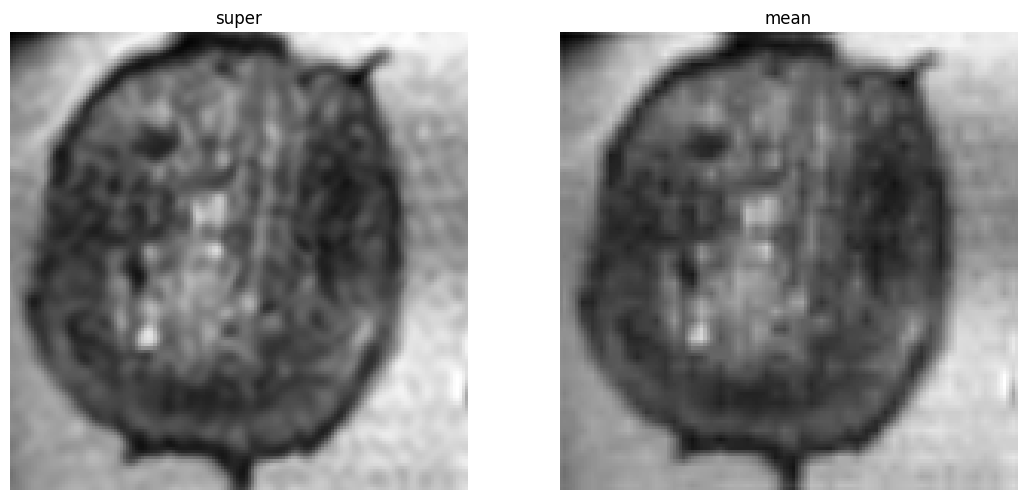

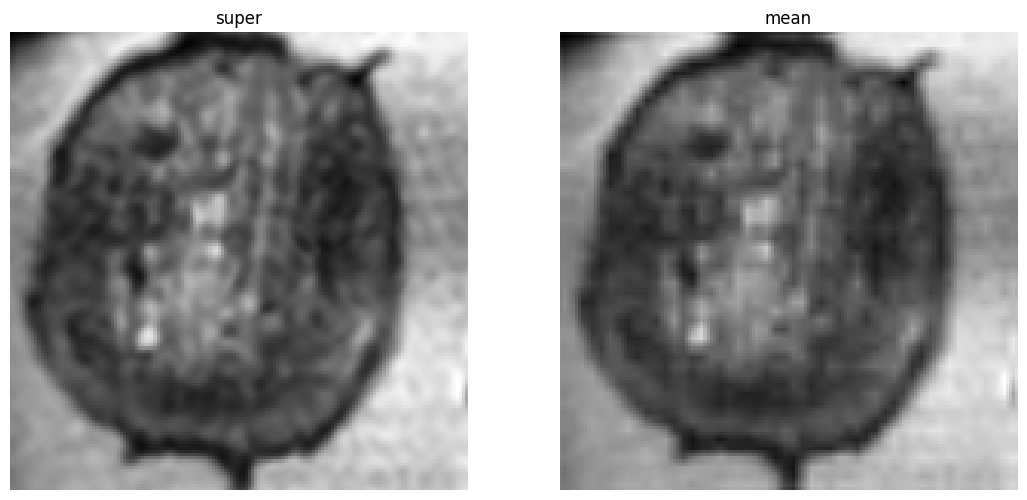

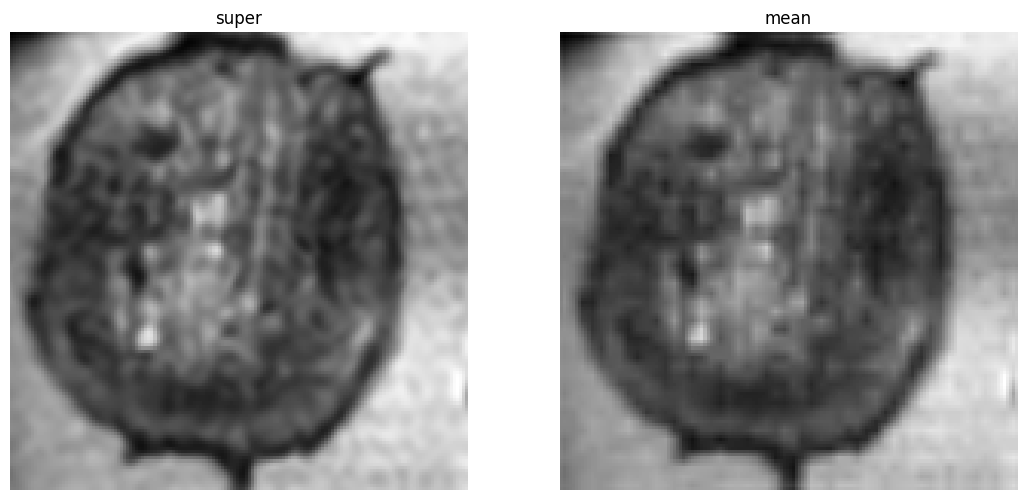

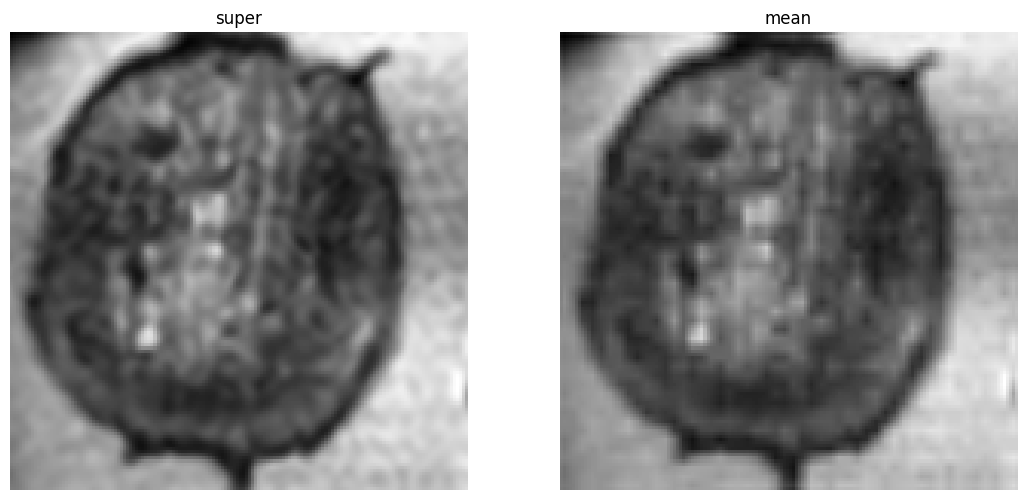

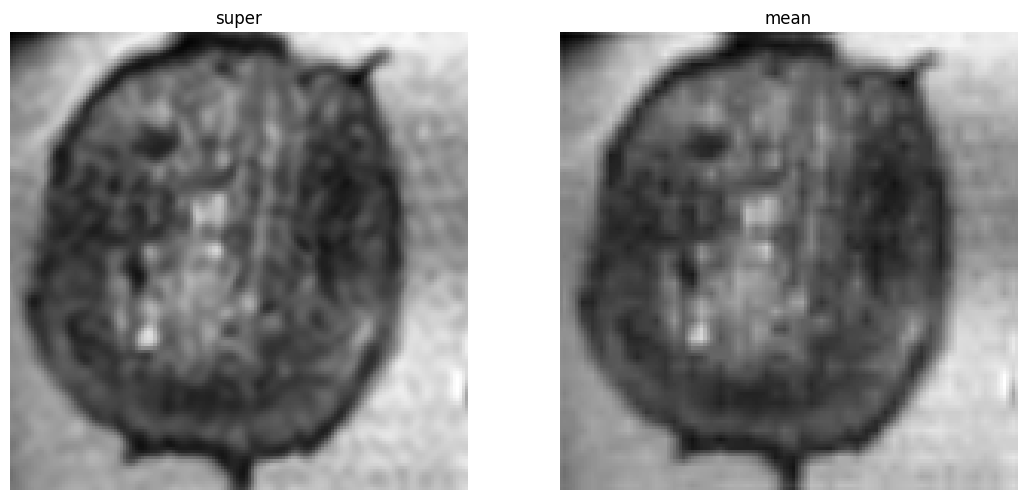

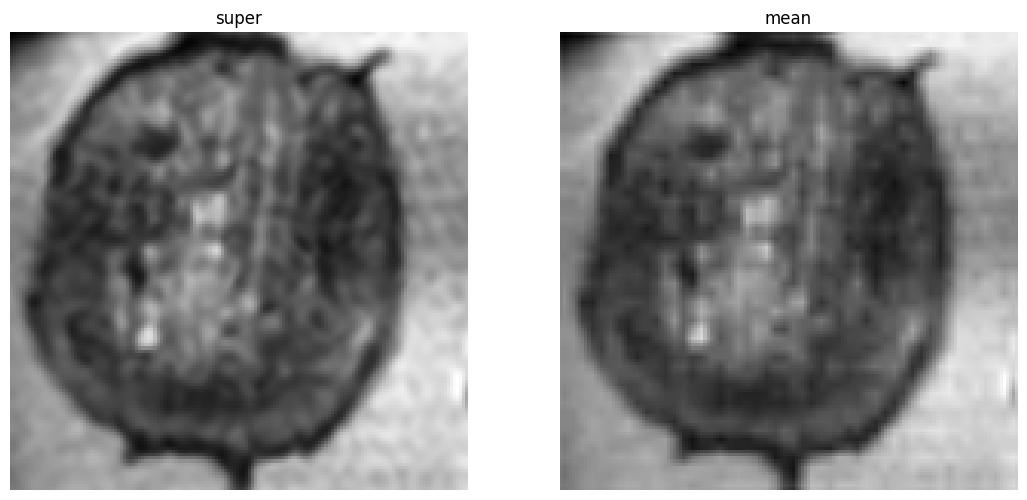

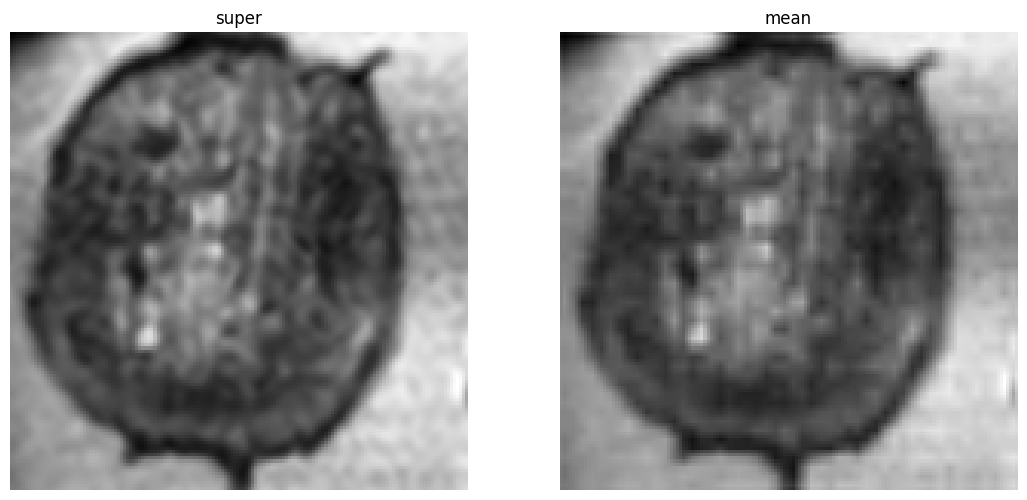

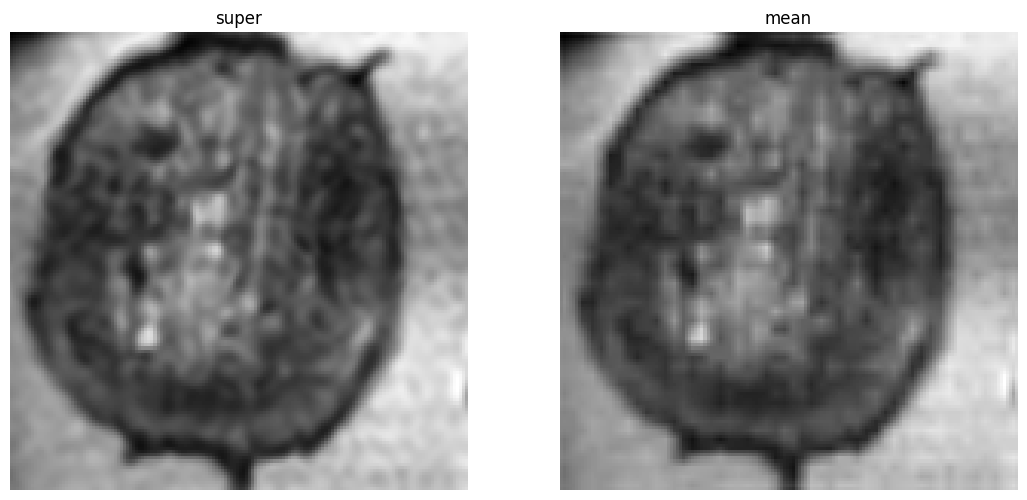

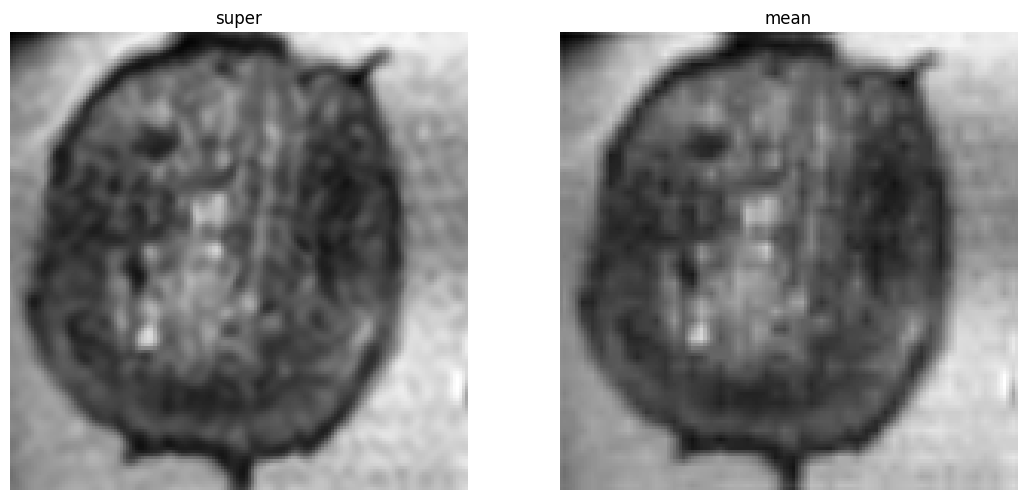

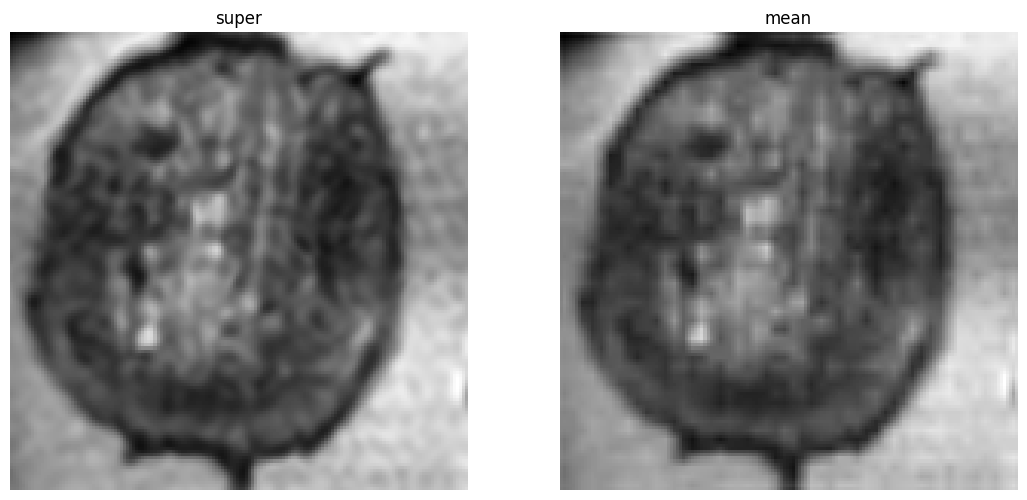

In [28]:
mean_img = np.zeros(_kiwi.dwi[40:90,20:70].shape)
ctr = 0
img_dataset = []
for inx in range(len(kiwi_scans)):
    _kiwi = kiwi_scans[inx]
    if not 'high' in _kiwi.img_id and not 'motion' in _kiwi.img_id:
        img = _kiwi.dwi[40:90,20:70]
        mean_img += _kiwi.dwi[40:90,20:70]
        ctr +=1
        img_dataset.append(Image.fromarray(img))
mean_img /= ctr

mean_dataset = ImageFitting_set([Image.fromarray(mean_img)])
dataset = ImageFitting_set(img_dataset)

INR = Siren(in_features=2*mapping_size, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3)
INR.cuda()
PerturbNet = PN(in_features=2*mapping_size, hidden_features=128)
PerturbNet.cuda()

inr_params = list(INR.parameters())
inr_optim = torch.optim.Adam(lr=1e-4, params=inr_params)
perturb_params = list(PerturbNet.parameters())
perturb_optim = torch.optim.Adam(lr=1e-6, params=perturb_params)
torch.cuda.empty_cache()
ctr = 0
new_loss = 1000

while True:
    ctr += 1

    if ctr < 500:
        ground_truth, model_input  = mean_dataset.pixels[0], mean_dataset.coords[0]
        ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
        model_input = input_mapping(model_input, B)
        ground_truth /= ground_truth.max()
        model_output = INR.forward(model_input)
        loss = ((model_output - ground_truth)**2).mean()
        inr_optim.zero_grad()
        loss.backward()
        inr_optim.step()
    else:
        if ctr%2:
            ground_truth, model_input  = mean_dataset.pixels[0], mean_dataset.coords[0]
            ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
            model_input = input_mapping(model_input, B)
            ground_truth /= ground_truth.max()
            model_output = INR.forward(model_input)
            loss = ((model_output - ground_truth)**2).mean()
            inr_optim.zero_grad()
            loss.backward()
            inr_optim.step()
        else:
            for sample in range(len(dataset)):
                ground_truth, model_input  = dataset.pixels[sample], dataset.coords[sample]
                ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
                model_input = input_mapping(model_input, B)
                ground_truth /= ground_truth.max()
                perturbed_input = PerturbNet.forward(model_input, sample, 1/100.)
                perturbed_input = input_mapping(perturbed_input, B)
                model_output = INR.forward(perturbed_input)
                if not sample:
                    loss = ((model_output - ground_truth)**2).mean()
                else:
                    loss += ((model_output - ground_truth)**2).mean()
        
            perturb_optim.zero_grad()
            loss.backward()
            perturb_optim.step()
    if not ctr%500:
        print(new_loss)
        model_input  = get_mgrid(150, 2).cuda()
        model_input  = input_mapping(model_input, B)
        recon = INR.forward(model_input).cpu().view(150,150).detach().numpy()
        fig, ax = plt.subplots(1,2,figsize=(13,6))
        ax[0].imshow(recon, cmap='gray')
        ax[0].set_title('super')
        ax[1].imshow(rescale(mean_img, 3), cmap='gray')
        ax[1].set_title('mean')
        for axi in range(2):
            ax[axi].axis('off')
        display.display(plt.gcf())  
    if ctr>10000 and loss.item() > new_loss:
        break      
    else:
        new_loss = loss.item()
print('Done')
PATH = 'toy_model.pt'
#torch.save(img_siren.state_dict(), PATH)

In [ ]:
dataloader = DataLoader(dataset, batch_size=1, pin_memory=True, num_workers=0)
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=64,
                      hidden_layers=3, perturb=False)
img_siren.cuda()
torch.cuda.empty_cache()
optim = torch.optim.Adam(lr=3e-4, params=img_siren.parameters())

In [ ]:
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=64,
                      hidden_layers=3, perturb=True)
PATH = 'model.pt'
img_siren.load_state_dict(torch.load(PATH))
img_siren.cuda()

In [ ]:
from IPython import display
params1 = list(img_siren.perturb_linear.parameters()) + list(img_siren.perturb_linear2.parameters())
params2 = list(img_siren.net.parameters())
perturb = True
if perturb:
    optim1 = torch.optim.Adam(lr=0.00001, params=params1)
    optim2 = torch.optim.Adam(lr=0, params=params2)
    perturb_degree = 1/100.
else:
    optim1 = torch.optim.Adam(lr=0, params=params1)
    optim2 = torch.optim.Adam(lr=3e-4, params=params2)
    perturb_degree = 0
    
ctr = 0
new_loss = 1000


while True:
    for sample in range(len(dataset)):
        ground_truth, model_input  = dataset.pixels[sample], dataset.coords[sample]
        ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
        ground_truth /= ground_truth.max()
        model_output = img_siren.forward(model_input, sample, perturb_degree)
        if not sample:
            loss = ((model_output - ground_truth)**2).mean()
        else:
            loss += ((model_output - ground_truth)**2).mean()
    if perturb:
        optim1.zero_grad()
    optim2.zero_grad()
    loss.backward()
    if perturb:
        optim1.step()
    optim2.step()
    if loss.item() > new_loss and ctr>1000:
        break      
    else:
        new_loss = loss.item()
    if not ctr%500:
        print(new_loss)
        model_input  = get_mgrid(100, 2).cuda()
        recon = img_siren.forward(model_input, 0, perturb_degree).cpu().view(100,100).detach().numpy()
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        ax[0].imshow(recon, cmap='gray')
        ax[0].set_title('super')
        ax[1].imshow(rescale(mean_img,2),cmap='gray')
        ax[1].set_title('mean')
        display.display(plt.gcf())


    ctr +=1
print('Done')
PATH = 'model.pt'
torch.save(img_siren.state_dict(), PATH)

In [ ]:
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3, perturb=True)
PATH = 'model.pt'
img_siren.load_state_dict(torch.load(PATH))
img_siren.cuda()

#### model_input  = get_mgrid(128, 2).cuda()
recon = img_siren(model_input).cpu().view(128,128).detach().numpy()


fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(recon, cmap='gray')
ax.set_title('super')


In [ ]:
mean_recon = np.zeros((128,128))
model_input  = get_mgrid(128, 2).cuda()
for i in range(9):
    model_output = img_siren(model_input, i, 1/64.0)
    mean_recon += model_output.cpu().view(128,128).detach().numpy()
mean_recon /= 9
#model_input  = get_mgrid(128, 2).cuda()
#model_output = img_siren(model_input).cpu().view((128,128)).detach().numpy()
fig, ax = plt.subplots(13,1,figsize=(6,72))
ax[0].imshow(mean_recon, cmap='gray')
ax[0].set_title('super')
ax[1].imshow(mean_img,cmap='gray')
ax[1].set_title('mean')
i=4
for inx in range(len(kiwi_scans)):
    _kiwi = kiwi_scans[inx]
    if 'low_high' in _kiwi.img_id:
        img = _kiwi.dwi[40:90,20:70]   
        ax[2].imshow(img,cmap='gray')
        ax[2].set_title(_kiwi.img_id)
    elif 'high.mat' in _kiwi.img_id:
        img = _kiwi.dwi[70:160,40:120]   
        ax[3].imshow(img,cmap='gray')
        ax[3].set_title(_kiwi.img_id)
    else:
        img = _kiwi.dwi[40:90,20:70]   
        ax[i].imshow(img,cmap='gray')
        ax[i].set_title(_kiwi.img_id)
        i+=1


In [ ]:
mean_recon = np.zeros((128,128))
model_input  = get_mgrid(128, 2).cuda()
for i in range(9):
    model_output = img_siren(model_input, i, 1/60.0)
    mean_recon += model_output.cpu().view(128,128).detach().numpy()
mean_recon /= 9
#model_input  = get_mgrid(128, 2).cuda()
#model_output = img_siren(model_input).cpu().view((128,128)).detach().numpy()
fig, ax = plt.subplots(1,4, figsize=(24,6))
ax[1].imshow(mean_recon, cmap='gray')
ax[1].set_title('super resolution')
ax[0].imshow(rescale(mean_img,2),cmap='gray')
ax[0].set_title('mean image')

for inx in range(len(kiwi_scans)):
    _kiwi = kiwi_scans[inx]
    if 'low_high' in _kiwi.img_id:
        img = _kiwi.dwi[40:90,20:70]   
        ax[2].imshow(rescale(img,2),cmap='gray')
        ax[2].set_title('no motion')
    elif 'high.mat' in _kiwi.img_id:
        img = _kiwi.dwi[70:150,34:115]   
        ax[3].imshow(img,cmap='gray')
        ax[3].set_title('high resolution')
for i in range(4):
    ax[i].axis('off')

In [ ]:
mean_recon = np.zeros((128,128))
model_input  = get_mgrid(128, 2).cuda()
for i in range(9):
    model_output = img_siren(model_input, i, 1/64.0)
    mean_recon += model_output.cpu().view(128,128).detach().numpy()
mean_recon /= 9
#model_input  = get_mgrid(128, 2).cuda()
#model_output = img_siren(model_input).cpu().view((128,128)).detach().numpy()
fig, ax = plt.subplots(13,1,figsize=(6,72))
ax[0].imshow(mean_recon, cmap='gray')
ax[0].set_title('super')
ax[1].imshow(mean_img,cmap='gray')
ax[1].set_title('mean')
i=4
for inx in range(len(kiwi_scans)):
    _kiwi = kiwi_scans[inx]
    if 'low_high' in _kiwi.img_id:
        img = _kiwi.dwi[40:90,20:70]   
        ax[2].imshow(img,cmap='gray')
        ax[2].set_title(_kiwi.img_id)
    elif 'high.mat' in _kiwi.img_id:
        img = _kiwi.dwi[70:160,40:120]   
        ax[3].imshow(img,cmap='gray')
        ax[3].set_title(_kiwi.img_id)
    else:
        img = _kiwi.dwi[40:90,20:70]   
        ax[i].imshow(img,cmap='gray')
        ax[i].set_title(_kiwi.img_id)
        i+=1


In [ ]:
dataloader = DataLoader(dataset, batch_size=1, pin_memory=True, num_workers=0)
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3, perturb=False)
img_siren.cuda()
torch.cuda.empty_cache()
optim = torch.optim.Adam(lr=3e-4, params=img_siren.parameters())

In [ ]:
#params1 = list(img_siren.perturb_linear.parameters()) + list(img_siren.perturb_linear2.parameters())
#optim1 = torch.optim.Adam(lr=3e-4, params=params1)
#params2 = list(img_siren.net.parameters()) + list(img_siren.final_linear.parameters())
#optim2 = torch.optim.Adam(lr=0.000001, params=params2)
ctr = 0
new_loss = 1000


while True:
    for sample in range(9):
        ground_truth, model_input  = dataset.pixels[sample], dataset.coords[sample]
        ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
        ground_truth /= ground_truth.max()
        model_output = img_siren(model_input)
        if not sample:
            loss = ((model_output - ground_truth)**2).mean()
        else:
            loss += ((model_output - ground_truth)**2).mean()
    optim.zero_grad()
    #optim2.zero_grad()
    loss.backward()
    optim.step()
    #optim2.step()
    if loss.item() > new_loss and ctr>100:
        break      
    else:
        new_loss = loss.item()
    if not ctr%500:
        print(new_loss)

    ctr +=1

In [ ]:
model_output.max()

In [ ]:
ground_truth.max()

In [ ]:
_case.pt_id

In [ ]:
_case = cases[0]
seed = 0
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3, perturb=True)



PATH = os.path.join('models', _case.pt_id + '_' + str(seed) + '.pt')
img_siren.load_state_dict(torch.load(PATH))
img_siren.cuda()

_slice = _case.cancer_slice
b = _case.b[3]
b0 = _case.b0[:, :, _slice]
dwi = _case.b3[:, :, _slice, :]
img = np.mean(dwi,-1)
mean_recon = np.zeros((128,128))
model_input  = get_mgrid(128, 2).cuda()
for i in range(_case.b3.shape[3]):
    model_output = img_siren(model_input, i, 1.0/128.0)
    mean_recon += model_output.cpu().view(128,128).detach().numpy()
mean_recon /= _case.b3.shape[3]
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[1].imshow(mean_recon)
axes[0].imshow(img)
axes[0].axis('off')
axes[1].axis('off')
plt.show()
print([round(x,3) for x in calculate_CNR_SNR(_case, img)])
print([round(x,3) for x in calculate_CNR_SNR(_case, mean_recon)])

In [ ]:
adc_in = calc_adc(img, _case.b0[:,:,_slice], _case.b[3])
adc_out = calc_adc(mean_recon, _case.b0[:,:,_slice], _case.b[3])

In [ ]:
print([round(x,2) for x in calculate_CNR_SNR(_case, adc_in)])
print([round(x,2) for x in calculate_CNR_SNR(_case, adc_out)])

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,18))
ax[0].imshow(adc_in[35:95, 35:95], cmap='gray',vmin=0.0, vmax = 3)
ax[1].imshow(adc_out[35:95, 35:95], cmap='gray',vmin=0.0,vmax=3)
adc_out.max()

In [ ]:
big_size = 512
big_mean = np.zeros((big_size,big_size))
model_input  = get_mgrid(big_size, 2).cuda()
for i in range(_case.b3.shape[3]):
    big_mean += img_siren(model_input, i, 1.0/128).cpu().view(big_size,big_size).detach().numpy()
big_mean /= _case.b3.shape[3]

fig, axes = plt.subplots(1,2, figsize=(25,25))
axes[1].imshow(big_mean, cmap='gray')
axes[0].imshow(rescale(img,4), cmap = 'gray')
axes[0].axis('off')
axes[1].axis('off')
plt.show()


fig, axes = plt.subplots(1,2, figsize=(25,25))
axes[1].imshow(calc_adc(big_mean, rescale(b0,4), _case.b[3])[35*4:95*4,35*4:95*4], cmap='gray',vmin=0,vmax=3)
axes[0].imshow(rescale(calc_adc(img, b0, _case.b[3]),4)[35*4:95*4,35*4:95*4], cmap = 'gray',vmin=0,vmax=3)
axes[0].axis('off')
axes[1].axis('off')
plt.show()